# Predicting Age of Awareness of Sexual Orientation

## Outline


  - [Introduction](#Introduction)  
  - [Data](#Data)  
      - [Initial Observations](#Initial-Observations)  
  - [Prediction](#Prediction)  
  - [Conclusion](#Conclusion) 


## Introduction

This notebook uses data from Pew Research Center's 2013 Survey of LGBT (lesbian, gay, bisexual, or transgender) Americans. The survey asked respondents to answer a myriad of questions, ranging from political views, perception of social acceptance of LGBT people, the coming out process, family, the importance of their identity, and religion. Using the answers to these questions, I will attempt to predict the age at which respondents said they knew for sure that they were LGBT. The dataset and report can be found [here](https://www.pewresearch.org/social-trends/2013/06/13/a-survey-of-lgbt-americans/).



## Data

In [1]:
pip install pyreadstat

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt

from sklearn import (
    linear_model, metrics, preprocessing, pipeline, neural_network, ensemble, model_selection, tree
)

import graphviz

In [3]:
df = pd.read_spss('lgbt.sav')
df.head()

,NEWCASEID,Q1,Q2,Q3_A,Q3_B,Q3_C,Q3_D,Q4,Q5,Q6_A,...,PPEDUCAT,PPETHM,PPHHHEAD,PPHHSIZEnew,PPT017,PPMSACAT,PPRENT,PPNET,weight,duration
0,1.0,Pretty happy,Wrong track,Mostly favorable,Mostly favorable,Very unfavorable,Mostly unfavorable,"A bigger government, providing more services",Most of the time,Some,...,Bachelor's degree or higher,"White, Non-Hispanic",No,4,No people < 18 yrs in HH,Metro,Occupied without payment of cash rent,No,0.1417,5.0
1,2.0,Pretty happy,Right direction,Very favorable,Mostly favorable,Very unfavorable,Mostly favorable,"A bigger government, providing more services",Most of the time,Some,...,Bachelor's degree or higher,"White, Non-Hispanic",Yes,1,No people < 18 yrs in HH,Metro,Owned or being bought by you or someone in you...,Yes,0.1417,9.0
2,3.0,Not too happy,Right direction,Very favorable,Mostly favorable,Very unfavorable,Mostly unfavorable,"A bigger government, providing more services",Some of the time,A lot,...,Bachelor's degree or higher,"White, Non-Hispanic",Yes,1,No people < 18 yrs in HH,Metro,Owned or being bought by you or someone in you...,Yes,0.1417,11.0
3,4.0,Pretty happy,Right direction,Mostly favorable,Mostly favorable,Mostly unfavorable,Mostly unfavorable,"A smaller government, providing fewer services",Most of the time,Some,...,Bachelor's degree or higher,"White, Non-Hispanic",Yes,2,No people < 18 yrs in HH,Metro,Owned or being bought by you or someone in you...,Yes,0.1417,11.0
4,5.0,Pretty happy,Right direction,Very favorable,Mostly favorable,Very unfavorable,Mostly unfavorable,"A bigger government, providing more services",Most of the time,Some,...,Bachelor's degree or higher,"White, Non-Hispanic",Yes,2,No people < 18 yrs in HH,Metro,Owned or being bought by you or someone in you...,Yes,0.1417,12.0


First some visualizations of age, race, education, and income to get an idea of the demographics of the people surveyed.

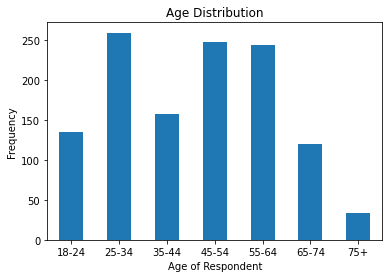

In [4]:
fig, ax = plt.subplots()
age = df.groupby('ppagecat')['NEWCASEID'].count()
age.plot(kind = 'bar',  xlabel = 'Age of Respondent', ylabel = 'Frequency', title = 'Age Distribution')
plt.xticks(rotation = 0);

In [5]:
# calculate the percentage of adults between 25 and 64
sum(age[1:5])/sum(age)

0.758563074352548

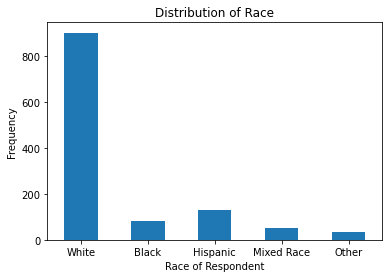

In [6]:
fig, ax = plt.subplots()
race = df.groupby('PPETHM')['NEWCASEID'].count()

# reindexed because they were in the wrong order
race = race.reindex(['White, Non-Hispanic','Black, Non-Hispanic', 'Hispanic', '2+ Races, Non-Hispanic', 'Other, Non-Hispanic'])
race.plot(kind = 'bar', xlabel = 'Race of Respondent', ylabel = 'Frequency', title = 'Distribution of Race')
ax.set_xticklabels(['White', 'Black', 'Hispanic', 'Mixed Race', 'Other'])
plt.xticks(rotation = 0);

In [7]:
# calculate the percentage of white people
race[0]/sum(race)

0.7527151211361738

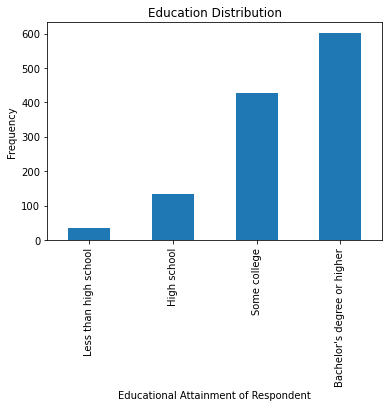

In [8]:
fig, ax = plt.subplots()
edu = df.groupby('PPEDUCAT')['NEWCASEID'].count()

# reindexed because they were in the wrong order
edu = edu.reindex(['Less than high school', 'High school',  'Some college', "Bachelor's degree or higher"])
edu.plot(kind = 'bar', xlabel = 'Educational Attainment of Respondent', ylabel = 'Frequency', title = 'Education Distribution');

In [9]:
# calculate the percentage of people with at least some college
sum(edu[2:4])/sum(edu)

0.8596491228070176

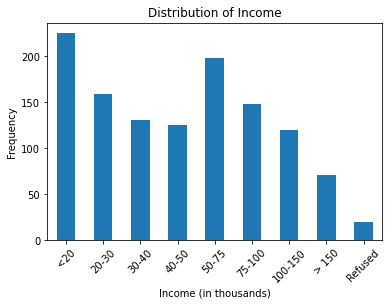

In [10]:
fig, ax = plt.subplots()
income = df.groupby('INCOME')['NEWCASEID'].count()

# reindexed because they were in the wrong order
income = income.reindex(['Less than $20,000', '$20,000 to under $30,000', '$30,000 to under $40,000',
                  '$40,000 to under $50,000', '$50,000 to under $75,000',
                  '$75,000 to under $100,000', '$100,000 to under $150,000', '$150,000 or more', 'Refused'])

income.plot(kind = 'bar', title = 'Distribution of Income', xlabel ="Income (in thousands)", ylabel = 'Frequency')
ax.set_xticklabels(['<20', '20-30', '30-40', '40-50', '50-75', '75-100', '100-150', '> 150', 'Refused']);
plt.xticks(rotation = 45);

In [11]:
# calculate the percentage of people making less than 75 000 per year
sum(income[0:5])/sum(income)

0.7000835421888053

### Initial Observations

- Most of the people surveyed: 
    - were between 25 and 64 (~76%)
    - were white (~75%)
    - have a bachelor's degree or at least some college (~86%)
    - made less than $75 000 a year (~70%)

## Prediction

Respondents were asked over 100 questions, so I will pick the ones that I think are the most relevant.

**Independent variable**: Q41, age of respondent when they knew for sure that they were LGBT

**Dependent variables**: 
   - Q11: support or oppose same-sex marriage
   - IDEO: political views
   - SEX: sex of respondent
   - Q27: degree of attraction to males and females
   - Q31: importance of being LGBT to overall identity
   - Q53: extent of social acceptance in the country (United States)
   - Q67: conflict between religious beliefs and sexual orientation
   - Q71: extent of social acceptance in city/town of residence
   - Q74: proportion of close friends who are LGBT
   - IMP: importance of religion in respondent's life
   - INCOME: income from all sources in 2012
   - ppagecat: age of respondent, split into seven bins
   - PPEDUCAT: educational attainment 
   - PPETHM: race/ethinicity

**Clean Data**

In [12]:
# Select relevant variables
df = df[['Q11', 'IDEO', 'SEX', 'Q27', 'Q31', 'Q41', 'Q53', 'Q67',
         'Q71', 'Q74', 'IMP', 'INCOME', 'ppagecat', 'PPEDUCAT', 'PPETHM']]


# Remove all rows where there was at least one question in which the respondent refused to answer or was unsure
df = df.replace('Refused', np.nan)
df = df.replace('Still not sure', np.nan)
df = df.dropna()

# Code the variables in an order that makes sense
df["Q11"] = df["Q11"].map({"Strongly favor": 4, 'Favor': 3, "Oppose": 2, "Strongly oppose": 1})
df['IDEO'] = df['IDEO'].map({"Very liberal": 5, "Liberal": 4, "Moderate": 3, "Conservative": 2, "Very conservative": 1})
df["SEX"] = df["SEX"].cat.codes
df["Q27"] = df["Q27"].map({"Only or mostly attracted to females": 5, "Somewhat more attracted to females than males": 4,
                   "About equally attracted to males and females": 3, "Somewhat more attracted to males than females": 2,
                   "Only or mostly attracted to males": 1})

df["Q31"] = df["Q31"].map({"Extremely important": 5, "Very important": 4, "Somewhat important": 3, 
                           "Not too important": 2, "Not at all important": 1})
# Q41 is already continuous
df["Q53"] = df["Q53"].map({"A lot": 4, "Some": 3, "Only a little": 2, "None at all": 1})
df["Q67"] = df["Q67"].cat.codes
df["Q71"] = df["Q71"].map({"A lot": 4, "Some": 3, "Only a little": 2, "None at all": 1})
df["Q74"] = df["Q74"].map({"All or most of them": 4, "Some of them": 3, "Only a few of them": 2, "None of them": 1})
df["IMP"] = df["IMP"].map({"Not at all important": 4, "Not too important": 3, "Somewhat important": 2, "Very important": 1})
df["INCOME"] = df["INCOME"].map({"$150,000 or more": 8, "$100,000 to under $150,000": 7, "$75,000 to under $100,000": 6,
                                "$50,000 to under $75,000": 5, "$40,000 to under $50,000": 4, "$30,000 to under $40,000": 3,
                                "$20,000 to under $30,000": 2, "Less than $20,000": 1})
df["ppagecat"] = df["ppagecat"].map({"18-24": 7, "25-34": 6, "35-44": 5, "45-54": 4, "55-64": 3, "65-74": 2, "75+": 1})
df["PPEDUCAT"] = df["PPEDUCAT"].map({"Bachelor's degree or higher": 4, "Some college": 3, 
                                     "High school": 2, "Less than high school": 1})


df = df.rename(columns = {'Q11': 'ssmsupport', 'Q27': 'attraction', 'Q31': 'identityimp', 'Q41': 'ageLGBT', 
                          'Q53': 'cntryaccept', 'Q67': 'rlgnconflict', 'Q71': 'cityaccept', 'Q74': 'friends', 
                          'IMP': 'religiosity', 'ppagecat': 'age', 'PPEDUCAT': 'education', 'PPETHM': 'race'})

# No ordinal ranking for race/ethinicity 
df = pd.get_dummies(df, columns = ["race"], drop_first = True) # avoid perfect multicollinearity
df.head()

,ssmsupport,IDEO,SEX,attraction,identityimp,ageLGBT,cntryaccept,rlgnconflict,cityaccept,friends,religiosity,INCOME,age,education,"race_Black, Non-Hispanic",race_Hispanic,"race_Other, Non-Hispanic","race_White, Non-Hispanic"
1,4,5,1,1,2,19.0,3,0,4,3,4,7,4,4,0,0,0,1
2,4,5,0,5,3,16.0,3,0,4,4,4,5,4,4,0,0,0,1
3,4,3,0,5,4,18.0,3,0,2,3,4,7,3,4,0,0,0,1
4,4,5,1,1,5,18.0,3,0,3,4,2,6,3,4,0,0,0,1
5,3,3,0,4,4,22.0,2,1,3,2,2,1,6,4,0,0,0,1


**Linear Regression**

In [13]:
X = df.drop(['ageLGBT'], axis = 1)
y = df['ageLGBT']

lr = linear_model.LinearRegression().fit(X, y)
pred = lr.predict(X)
metrics.mean_squared_error(y, pred)

62.334480957943455

**Lasso**

In [14]:
# no cross validation
lasso = linear_model.Lasso().fit(X, y)
predl = lasso.predict(X)
metrics.mean_squared_error(y, predl)

66.0265148151

In [15]:
# use 5-fold cross validation to find alpha that gives the lowest mse
cv = model_selection.RepeatedKFold(random_state = 1)
lasso_cv = linear_model.LassoCV(alphas = np.arange(0.01, 1, 0.01), cv=cv, n_jobs = -1)
mod = lasso_cv.fit(X, y)
predl = mod.predict(X)
metrics.mean_squared_error(y, predl)

62.74654013606901

**Compare coefficients**

In [16]:
lasso_coef = pd.Series(dict(zip(list(X), lasso.coef_)))
lr_coef = pd.Series(dict(zip(list(X), lr.coef_)))
coefs = pd.DataFrame(dict(lasso = lasso_coef, linear = lr_coef))
coefs

,lasso,linear
ssmsupport,0.000000,0.642018
IDEO,0.000000,-0.110977
SEX,-0.000000,-2.097794
attraction,0.764386,0.772832
identityimp,-0.152699,-0.768748
cntryaccept,-0.000000,-0.299334
rlgnconflict,-0.000000,0.346151
cityaccept,-0.000000,0.183345
friends,-0.000000,-0.710135
religiosity,-0.000000,-0.113838


**Regression Tree**

In [17]:
# split data into training and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state = 0)

# fit regression tree with training data
trained = tree.DecisionTreeRegressor(max_depth = 3).fit(X_train, y_train)
pred = trained.predict(X_test)
metrics.mean_squared_error(y_test, pred)

66.07722496672147

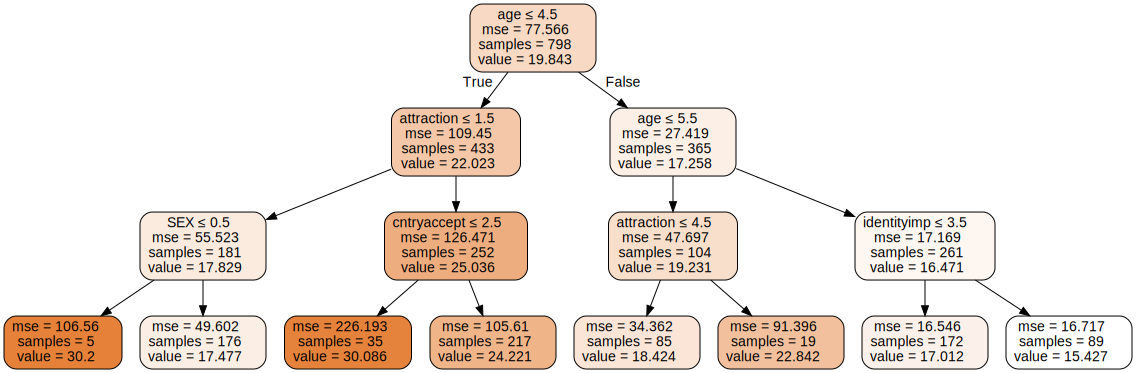

In [18]:
tree_graph = tree.export_graphviz(trained, out_file=None,
                                  feature_names=['ssmsupport', 'IDEO', 'SEX', 'attraction', 'identityimp',
       'cntryaccept', 'rlgnconflict', 'cityaccept', 'friends', 'religiosity',
       'INCOME', 'age', 'education', 'race_Black, Non-Hispanic',
       'race_Hispanic', 'race_Other, Non-Hispanic',
       'race_White, Non-Hispanic'], filled=True, rounded=True, special_characters=True)

graphviz.Source(tree_graph)

**Random Forest**

In [19]:
forest = ensemble.RandomForestRegressor(n_estimators = 1000, random_state = 0, max_features = 'sqrt', oob_score = True).fit(X_train, y_train)
rf_pred = forest.predict(X_test)
metrics.mean_squared_error(y_test, rf_pred)

62.89803252194758

In [20]:
features = ['ssmsupport', 'IDEO', 'SEX', 'attraction', 'identityimp', 'cntryaccept', 'rlgnconflict', 
            'cityaccept', 'friends', 'religiosity', 'INCOME', 'age', 'education', 'race_Black', 
            'Non-Hispanic', 'race_Hispanic', 'race_Other, Non-Hispanic', 'race_White, Non-Hispanic']
importances = forest.feature_importances_
feat = pd.Series(dict(zip(features, importances)))
feat = feat.sort_values()
feat

race_Hispanic               0.004221
race_Black                  0.006402
Non-Hispanic                0.014955
race_Other, Non-Hispanic    0.020685
rlgnconflict                0.029030
ssmsupport                  0.033026
SEX                         0.036064
education                   0.055651
friends                     0.063156
cityaccept                  0.066310
cntryaccept                 0.067391
IDEO                        0.068096
religiosity                 0.070783
identityimp                 0.083735
INCOME                      0.105470
attraction                  0.107549
age                         0.167477
dtype: float64

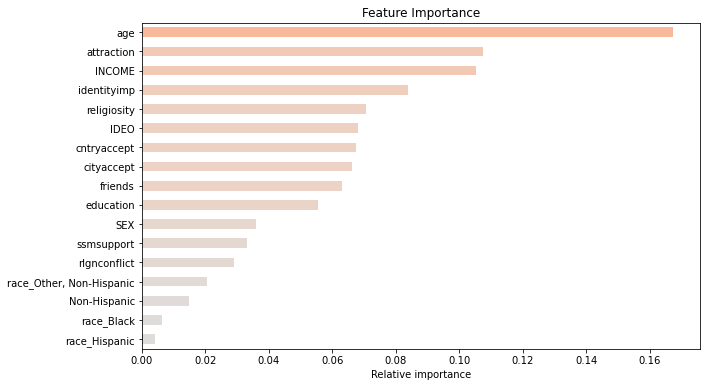

In [21]:
# added 0.5 to make the colors easier to distinguish
colors = plt.cm.coolwarm(np.sort(importances) + 0.5)

fig, ax = plt.subplots(figsize = (10, 6))
feat.plot(kind = 'barh', color = colors, title = 'Feature Importance');
plt.xlabel('Relative importance');

**Neural network**

In [22]:
# validation_fraction set to match the default in train_test_split
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(), 
    neural_network.MLPRegressor((40, 30), max_iter = 1000, solver = 'sgd', batch_size = 100, validation_fraction = 0.25) 
)

nn_scaled_model.fit(X, y)
mse_nn_scaled = metrics.mean_squared_error(y, nn_scaled_model.predict(X))
mse_nn_scaled

6.562507369263904

## Conclusion

- Linear regression, Lasso (with five-fold cross validation), and Random Forests give approximately the same mean-squared error (MSE). The regression tree, even after pruning to a depth of 3, had a slightly larger MSE. A multilayer perceptron fit using stochastic gradient descent had the lowest MSE. 

- The top 3 features for predicting the age of being certain of one's sexual orientation are age, attraction, and income based on random forests.